# Trial 2 Undergraduate Thesis
Goal :
- Create XGBoost and Linear Regresion Model
- Get insights from the datas
- Get the best blanket configuration

Name : Husni Naufal Zuhdi (413821)

## Regression exercise with XGBoost

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv as csv
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot

import xgboost
from xgboost import plot_importance
import sklearn
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from scipy.stats import skew
from collections import OrderedDict

In [3]:
from google.cloud import storage
client = storage.Client.from_service_account_json(
    'key.json', project='iter-tritium-breeding-xgboost'
)

In [4]:
enrich_lis = [0.1, 0.3, 0.5, 0.7, 0.9]
mod_ratios = [0, 0.1, 0.2, 0.3]
neutron_multis = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
bucket = client.bucket("iter-tritium-breeding-xgboost-bucket")
result_uri = "v2/results/"

for enrich_li in enrich_lis:
    for mod_ratio in mod_ratios:
        for neutron_multi in neutron_multis:
            try:
                print("Downloading : " + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
                blob = bucket.blob(result_uri + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
                blob.download_to_filename("result/" + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-100-1000.json")
            except Exception:
                pass

In [25]:
# Read folder contain simulation results
path = "/home/husninaufalz/iter-tritium-breeding-xgboost/jupyter-notebooks/2-data-analysis/result"
results = os.listdir(path=path)
results.sort()
results = results[1:]

In [26]:
results[0]

'0.1-0-0-100-1000.json'

In [31]:
# Read data in each folder
data = []
for result in results:
    # Find enrichment feature
    folder_path = path + str(result)
    folder_list = result.split('-')
    folder_list = folder_list[0:3]
    # print(folder_list)
    # Read tbr and std dev data
    try:
        json_result = pd.read_json(path + "/" + result)
        json_result = json_result["blanket_fluid_mat_(n,Xt)"]["events per source particle"]
        data.append([folder_list[0], folder_list[1], folder_list[2], json_result['result'], json_result['std. dev.']])
    except Exception:
        pass
df = pd.DataFrame(data, columns=['Li6_enrichment', 'Moderator_ratio','Neutron_multiplier', 'Tbr', 'Stddev'])

In [39]:
df.Li6_enrichment = df.Li6_enrichment.astype(float)
df.Moderator_ratio = df.Moderator_ratio.astype(float)
df.Neutron_multiplier = df.Neutron_multiplier.astype(float)
df

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr,Stddev
0,0.1,0.0,0.0,0.873481,0.002972
1,0.1,0.1,0.0,0.680171,0.002988
2,0.1,0.1,0.1,0.686477,0.003014
3,0.1,0.1,0.3,0.700291,0.002765
4,0.1,0.1,0.5,0.708109,0.002861
5,0.1,0.1,0.7,0.719376,0.002800
6,0.1,0.1,0.9,0.733147,0.002679
7,0.1,0.2,0.1,0.685526,0.002841
8,0.1,0.2,0.3,0.706442,0.003032
9,0.1,0.2,0.5,0.731359,0.002879


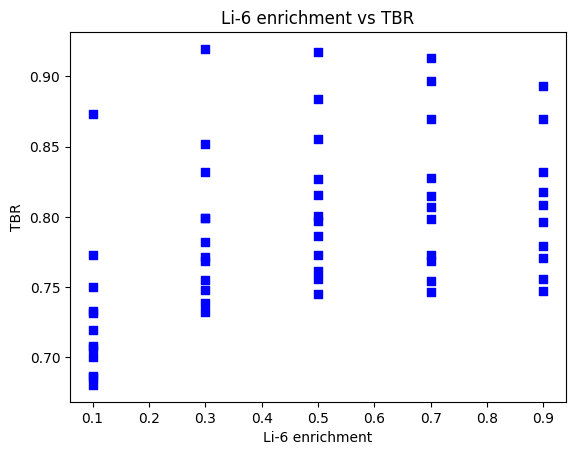

In [40]:
plt.scatter(df.Li6_enrichment, df.Tbr, c = "blue", marker = "s")
plt.title("Li-6 enrichment vs TBR")
plt.xlabel("Li-6 enrichment")
plt.ylabel("TBR")

plt.show()

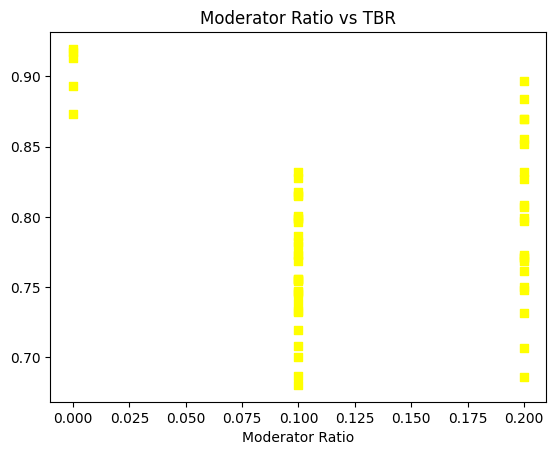

In [41]:
plt.scatter(df.Moderator_ratio, df.Tbr, c = "yellow", marker = "s")
plt.title("Moderator Ratio vs TBR")
plt.xlabel("Moderator Ratio")

plt.show()

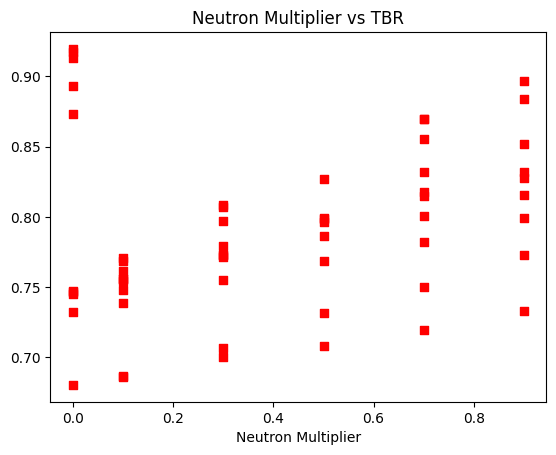

In [42]:
plt.scatter(df.Neutron_multiplier, df.Tbr, c = "red", marker = "s")
plt.title("Neutron Multiplier vs TBR")
plt.xlabel("Neutron Multiplier")

plt.show()

In [43]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [44]:
features_columns = [col for col in df.columns if col not in ['Tbr', 'Stddev']]
model.fit(df[features_columns],df['Tbr'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [49]:
OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('Li6_enrichment', 81), ('Neutron_multiplier', 2)])

In [50]:
data_test = [[0.1, 0.1, 0.2],
             [0.1, 0.1, 0.3],
             [0.1, 0.1, 0.4],
             [0.1, 0.1, 0.5],
             [0.1, 0.1, 0.6],
             [0.1, 0.1, 0.7],
             [0.1, 0.1, 0.8],
             [0.1, 0.1, 0.9],
             [0.1, 0.1, 1],
             [0.1, 0.2, 0.2],
             [0.1, 0.2, 0.3],
             [0.1, 0.2, 0.4],
             [0.1, 0.2, 0.5],
             [0.1, 0.2, 0.6],
             [0.1, 0.2, 0.7],
             [0.1, 0.2, 0.8],
             [0.1, 0.2, 0.9],
             [0.1, 0.2, 1],]
df_test = pd.DataFrame(data_test, columns=['Li6_enrichment', 'Moderator_ratio','Neutron_multiplier'])
df_test

,Li6_enrichment,Moderator_ratio,Neutron_multiplier
0,0.1,0.1,0.2
1,0.1,0.1,0.3
2,0.1,0.1,0.4
3,0.1,0.1,0.5
4,0.1,0.1,0.6
5,0.1,0.1,0.7
6,0.1,0.1,0.8
7,0.1,0.1,0.9
8,0.1,0.1,1.0
9,0.1,0.2,0.2


In [51]:
# make predictions for test data
y_pred = model.predict(df_test)
y_pred

array([0.7527469 , 0.7527469 , 0.7527469 , 0.7527469 , 0.75291085,
       0.75291085, 0.75291085, 0.75291085, 0.75291085, 0.7527469 ,
       0.7527469 , 0.7527469 , 0.7527469 , 0.75291085, 0.75291085,
       0.75291085, 0.75291085, 0.75291085], dtype=float32)

In [54]:
# for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1],
   'min_child_weight':[1.5,5],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[1000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6, 0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1,
                                 n_estimators=1000,
                                 max_depth=2,
                                 min_child_weight=1,
                                 gamma=0,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 nthread=8,
                                 scale_pos_weight=1,
                                 seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6, verbose=10, scoring='neg_mean_squared_error')
gsearch1.fit(df[features_columns], df['Tbr'])

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


KeyboardInterrupt: 

## Contoh

In [2]:
train_dataset=pd.read_csv('../0-xgboost-training/train.csv', header=0)
test_dataset=pd.read_csv('../0-xgboost-training/test.csv', header=0)

In [3]:
categorical_features=['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
                      'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                      'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
                     'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence',
                     'MiscFeature','SaleType','SaleCondition']
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
train_dataset.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
test_dataset.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [5]:
#thanks to https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

every_column_non_categorical= [col for col in train_dataset.columns if col not in categorical_features and col not in ['Id'] ]

#log transform skewed numeric features:
numeric_feats = train_dataset[every_column_non_categorical].dtypes[train_dataset.dtypes != "object"].index

#skewed_feats = train_dataset[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#skewed_feats = skewed_feats[skewed_feats > 0.75]
#skewed_feats = skewed_feats.index

train_dataset[numeric_feats] = np.log1p(train_dataset[numeric_feats])

every_column_non_categorical= [col for col in test_dataset.columns if col not in categorical_features and col not in ['Id'] ]
numeric_feats = test_dataset[every_column_non_categorical].dtypes[test_dataset.dtypes != "object"].index
test_dataset[numeric_feats] = np.log1p(test_dataset[numeric_feats])

In [6]:
features_with_nan=['Alley','MasVnrType','BsmtQual','BsmtQual','BsmtCond','BsmtCond','BsmtExposure',
                   'BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish']
#function that creates a column for every value it might have
def ConverNaNToNAString(data, columnList):
    for x in columnList:       
        data[x] =str(data[x])              
            

ConverNaNToNAString(train_dataset, features_with_nan)
ConverNaNToNAString(test_dataset, features_with_nan)

In [7]:
#function that creates a column for every value it might have
def CreateColumnPerValue(data, columnList):
    for x in columnList:

        values=pd.unique(data[x])
        
        for v in values:
            column_name=x+"_"+str(v)   
            data[column_name]=(data[x]==v).astype(float)
    
        data.drop(x, axis=1, inplace=True)
        

In [8]:
#CreateColumnPerValue(train_dataset,categorical_features)
#CreateColumnPerValue(test_dataset,categorical_features)

train_dataset = pd.get_dummies(train_dataset,columns =categorical_features)
test_dataset = pd.get_dummies(test_dataset,columns =categorical_features)

#train_dataset = train_dataset.fillna(train_dataset.mean())
#test_dataset = test_dataset.fillna(test_dataset.mean())

In [9]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [10]:
every_column_except_y= [col for col in train_dataset.columns if col not in ['SalePrice','Id']]
model.fit(train_dataset[every_column_except_y],train_dataset['SalePrice'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [11]:
OrderedDict(sorted(model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 2487),
             ('LotFrontage', 2372),
             ('BsmtUnfSF', 2295),
             ('GrLivArea', 2214),
             ('GarageYrBlt', 2072),
             ('TotalBsmtSF', 1805),
             ('1stFlrSF', 1767),
             ('GarageArea', 1727),
             ('BsmtFinSF1', 1525),
             ('WoodDeckSF', 1468),
             ('OpenPorchSF', 1414),
             ('YearBuilt', 1317),
             ('MasVnrArea', 1260),
             ('MoSold', 1220),
             ('2ndFlrSF', 1091),
             ('YearRemodAdd', 1036),
             ('YrSold', 682),
             ('OverallCond', 630),
             ('OverallQual', 553),
             ('EnclosedPorch', 536),
             ('TotRmsAbvGrd', 525),
             ('BsmtFinSF2', 460),
             ('BedroomAbvGr', 436),
             ('ScreenPorch', 373),
             ('Fireplaces', 306),
             ('Neighborhood_NAmes', 281),
             ('SaleCondition_Normal', 232),
             ('BsmtFullBath', 225),
             (

In [12]:
#Let's remove the less important ones 
most_relevant_features= list( dict((k, v) for k, v in model.get_booster().get_fscore().items() if v >= 10).keys())
print(most_relevant_features)

['GrLivArea', 'OverallQual', 'ExterQual_TA', 'GarageCars', 'FullBath', 'TotalBsmtSF', 'YearBuilt', 'Fireplaces', 'GarageCond_TA', 'CentralAir_Y', 'YearRemodAdd', '1stFlrSF', 'MSSubClass_30', 'MSZoning_C (all)', 'CentralAir_N', 'MSZoning_RM', 'OverallCond', 'LotArea', 'GarageArea', 'GarageYrBlt', 'KitchenAbvGr', 'BsmtFinSF1', 'BedroomAbvGr', 'MSSubClass_90', 'RoofStyle_Gable', 'Functional_Min2', 'LotFrontage', 'HouseStyle_1.5Fin', 'Fence_GdWo', 'BsmtUnfSF', 'KitchenQual_Ex', 'EnclosedPorch', 'Exterior1st_AsbShng', 'BsmtFullBath', 'KitchenQual_TA', 'Neighborhood_IDOTRR', 'HeatingQC_Fa', 'PavedDrive_N', 'BsmtFinSF2', 'OpenPorchSF', 'SaleCondition_Normal', 'ExterCond_Fa', 'SaleCondition_Abnorml', 'Condition2_Norm', 'Neighborhood_Edwards', 'HeatingQC_Ex', 'Neighborhood_Sawyer', 'MSZoning_RL', 'Exterior2nd_Stucco', 'Exterior1st_MetalSd', 'Condition1_PosN', 'WoodDeckSF', 'Functional_Typ', 'Exterior1st_Stucco', 'PoolArea', 'Neighborhood_CollgCr', 'Condition1_Artery', 'SaleType_COD', 'TotRmsAbv

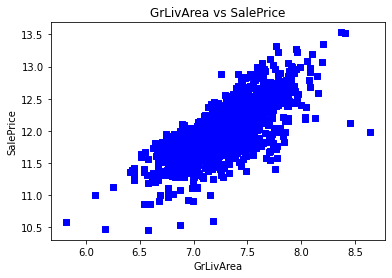

In [13]:
plt.scatter(train_dataset.GrLivArea, train_dataset.SalePrice, c = "blue", marker = "s")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

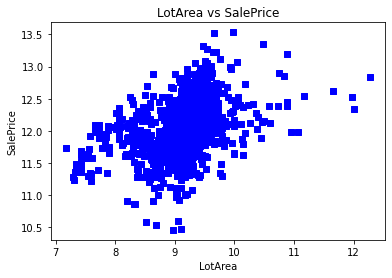

In [14]:
plt.scatter(train_dataset.LotArea, train_dataset.SalePrice, c = "blue", marker = "s")
plt.title("LotArea vs SalePrice")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [15]:
#removing outliers
train_dataset = train_dataset[train_dataset.GrLivArea < 8.25]
train_dataset = train_dataset[train_dataset.LotArea < 11.5]
train_dataset = train_dataset[train_dataset.SalePrice<13]
train_dataset = train_dataset[train_dataset.SalePrice>10.75]
train_dataset.drop("Id", axis=1, inplace=True)

In [16]:
train_x=train_dataset[most_relevant_features]
train_y=train_dataset['SalePrice']

# for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8]
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None, nthread=6,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=1, seed=27, subsample=0.8,
                                    tree_method=None, validate_parameters=None,


In [17]:
print (gsearch1.cv_results_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

{'mean_fit_time': array([1055.35864592, 1056.6274116 ,  467.74872556]), 'std_fit_time': array([ 17.90112787,  12.71408114, 483.56443659]), 'mean_score_time': array([0.06667628, 0.07245083, 0.02281756]), 'std_score_time': array([0.00741993, 0.01637727, 0.02429572]), 'param_colsample_bytree': masked_array(data=[0.4, 0.6, 0.8],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'colsample_bytree': 0.4}, {'colsample_bytree': 0.6}, {'colsample_bytree': 0.8}], 'split0_test_score': array([-0.01024378, -0.01100736, -0.00959072]), 'split1_test_score': array([-0.01437021, -0.01321371, -0.01432438]), 'split2_test_score': array([-0.01762626, -0.01685425, -0.01655762]), 'split3_test_score': array([-0.0106963 , -0.01099079, -0.01085   ]), 'split4_test_score': array([-0.01436772, -0.01384594, -0.01505679]), 'mean_test_score': array([-0.01346086, -0.01318241, -0.0132759 ]), 'std_test_score': array([0.00272001, 0.002166  , 0.00262702]), 'rank_test_sco

In [18]:
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model.fit(train_x,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [19]:
test_dataset['Prediction'] = np.expm1(best_xgb_model.predict(test_dataset[most_relevant_features]))
filename = '/xgboost-training/submission.csv'
pd.DataFrame({'Id': test_dataset.Id, 'SalePrice': test_dataset.Prediction}).to_csv(filename, index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/xgboost-training/submission.csv'

In [ ]:
print(test_dataset['Prediction'].head())
print(test_dataset['Prediction'].count())

In [ ]:
# make predictions for test data
y_pred = best_xgb_model.predict(test_dataset[most_relevant_features])
predictions = [round(value) for value in y_pred]

In [ ]:
# Harus di split di awal
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))